This notebook creates a roofline plot from bandwidth and message size data. It requires hard-coding the theoretical/achieved peak bandwidth values and also guestimating the latency values for a trial-and-error plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
font = { 'size'   : 16}
plt.rc('font', **font)

colors = ['b','r','g','m','y','c']
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

In [3]:
with open("data/atomic_cas_B8_T512_I1000_inter.csv", "r") as csvfile:
    csvreader = csv.reader(csvfile)
    mybw_inter = []
    mysize = []
    for row in csvreader:
        mysize.append(int(row[3]))
        mybw_inter.append(float(row[7])*1024)


print(mysize)
print(mybw_inter)

[8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216]
[1.892352, 3.308544, 5.101568, 6.940672, 8.349696, 9.233408, 9.90208, 10.185728, 10.339328, 10.266624, 10.436608, 10.426368, 10.413056, 10.45504, 10.463232, 10.473472, 10.477568, 10.479616, 10.478592, 10.478592, 10.479616, 10.478592]


In [4]:
with open("data/atomic_cas_B8_T512_I1000_intra.csv", "r") as csvfile:
    csvreader = csv.reader(csvfile)
    mybw_intra = []
    mysize = []
    for row in csvreader:
        mysize.append(int(row[3]))
        mybw_intra.append(float(row[7])*1024)


print(mysize)
print(mybw_intra)

[8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216]
[3.003392, 6.249472, 12.338176, 22.611968, 45.18912, 90.404864, 180.702208, 361.361408, 654.843904, 976.533504, 1945.833472, 3477.834752, 6046.88384, 7651.100672, 8836.276224, 10582.38464, 11461.21216, 11976.333312, 11778.361344, 12351.883264, 12390.269952, 12293.91872]


In [12]:
nx = 1000
xmin = 0
xmax = 8

scomp_x_elbow = []
scomp_ix_elbow = []
smem_x_elbow = []
smem_ix_elbow = []

x = np.logspace(xmin,xmax,nx)

# latency in us in increasing order
smemroofs = [3, 5]
# bandwidth in MB/s in decreasing order
scomproofs = [46*1024, 32*1024, 12*1024]

for roof in scomproofs:
    for ix in range(1,nx):
        if  x[ix]/smemroofs[0]  >= roof and  x[ix-1]/smemroofs[0] < roof:
            scomp_x_elbow.append(x[ix-1])
            scomp_ix_elbow.append(ix-1)
            break


for roof in smemroofs:
    for ix in range(1,nx):
        if (scomproofs[0] <= x[ix]/roof and scomproofs[0] > x[ix-1]/roof):
            smem_x_elbow.append(x[ix-1])
            smem_ix_elbow.append(ix-1)
            break

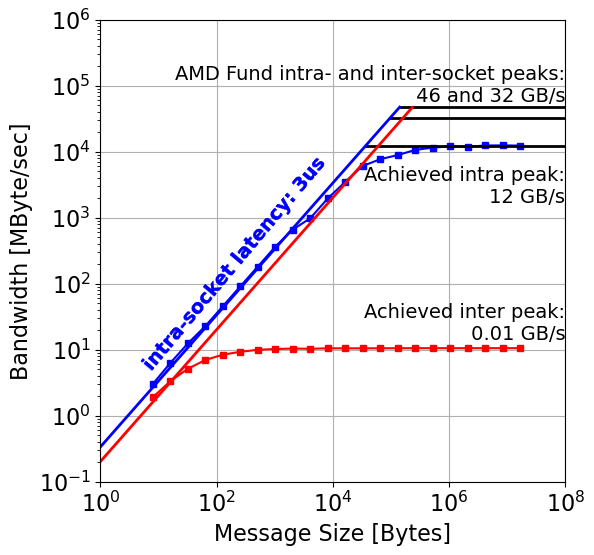

In [14]:
fig = plt.figure(1,figsize=(6,6))
plt.clf()
ax = fig.gca()
ax.set_xlabel('Message Size [Bytes]')
ax.set_ylabel('Bandwidth [MByte/sec]')
ax.set_yscale('log',base=10)
ax.set_xscale('log',base=10)
ax.set_xlim(10**xmin, 10**xmax)
ax.set_ylim(0.1, 10**6)

plt.plot(mysize, mybw_intra,
         c=colors[0], marker='s', linestyle="-", linewidth=1.5, markersize=4)
plt.plot(mysize, mybw_inter,
         c=colors[1], marker='s', linestyle="-", linewidth=1.5, markersize=4)


scalingFactorForRoofs=1

for i in range(0,len(scomproofs)):
    roof = scomproofs[i]
    y = np.ones(len(x)) * roof / scalingFactorForRoofs
    ax.plot(x[scomp_ix_elbow[i]:],y[scomp_ix_elbow[i]:],c='k',ls='-',lw='2')


for i in range(0,len(smemroofs)):
    roof = smemroofs[i]
    y = x / roof / scalingFactorForRoofs
    ax.plot(x[:smem_ix_elbow[i]+1],y[:smem_ix_elbow[i]+1],c=colors[i],ls='-',lw='2')

#adding text inside the plot
plt.text(10**8, 46*1024*1.2, 'AMD Fund intra- and inter-socket peaks:\n 46 and 32 GB/s',
         fontsize = 14, horizontalalignment = 'right')
plt.text(10**8, 12*1024*0.5, 'Achieved intra peak:\n 12 GB/s',
         fontsize = 14, horizontalalignment = 'right', verticalalignment = 'top')
plt.text(10**8, 0.01*1024*1.2, 'Achieved inter peak:\n 0.01 GB/s',
         fontsize = 14, horizontalalignment = 'right', verticalalignment = 'bottom')
plt.text(5, 5, 'intra-socket latency: 3us', color=colors[0], fontsize = 14,  weight='bold', rotation=50)
plt.text(5, 5, 'intra-socket latency: 3us', color=colors[0], fontsize = 14,  weight='bold', rotation=50)


plt.grid()
plt.show()